## Capstone Assignment – Delivery Route Optimization

Import Libraries

In [10]:
!pip install memory_profiler --quiet
!pip install networkx --quiet

import itertools
import time
import matplotlib.pyplot as plt
import networkx as nx
from memory_profiler import memory_usage

Input Modeling

In [11]:
locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9,12), 'weight': 10},
    'C2': {'value': 60, 'time': (10,13), 'weight': 20},
    'C3': {'value': 40, 'time': (11,14), 'weight': 15},
}

vehicle_capacity = 30


Recurrence: Delivery Cost Estimation

In [12]:
def delivery_cost(pos, visited):
    # visited = bitmask integer
    if visited == (1 << len(locations)) - 1:
        return distance_matrix[pos][0]

    best = float('inf')
    for nxt in range(1, len(locations)):
        if not visited & (1 << nxt):
            cost = distance_matrix[pos][nxt] + delivery_cost(nxt, visited | (1 << nxt))
            best = min(best, cost)
    return best

print("Recursive Cost Estimate:", delivery_cost(0, 1))

Recursive Cost Estimate: 18


Greedy + DP

In [13]:
def greedy_knapsack(parcels, capacity):
    items = []
    for c in parcels:
        v = parcels[c]['value']
        w = parcels[c]['weight']
        items.append((c, v, w, v/w))

    items.sort(key=lambda x: x[3], reverse=True)

    total = 0
    selected = []

    for c, v, w, _ in items:
        if w <= capacity:
            selected.append(c)
            total += v
            capacity -= w

    return selected, total

selected_customers, total_value = greedy_knapsack(parcels, vehicle_capacity)
selected_customers, total_value


(['C1', 'C2'], 110)

Delivery Time Window Validity

In [14]:
def within_time_window(customer, arrival):
    e, l = parcels[customer]['time']
    return e <= arrival <= l


Graph Algorithms (Dijkstra + MST)

In [15]:
import heapq

def dijkstra(start):
    n = len(locations)
    dist = [float('inf')] * n
    dist[start] = 0
    pq = [(0, start)]

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]: continue

        for v in range(n):
            if distance_matrix[u][v] > 0:
                nd = d + distance_matrix[u][v]
                if nd < dist[v]:
                    dist[v] = nd
                    heapq.heappush(pq, (nd, v))
    return dist

print("Shortest Distance from Warehouse:")
print(dict(zip(locations, dijkstra(0))))


Shortest Distance from Warehouse:
{'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}


MST (Prim’s Algorithm)

In [16]:
def prim_mst():
    n = len(locations)
    selected = [False]*n
    selected[0] = True
    edges = []

    for _ in range(n-1):
        best = (float('inf'), None, None)
        for u in range(n):
            if selected[u]:
                for v in range(n):
                    if not selected[v] and distance_matrix[u][v] < best[0]:
                        best = (distance_matrix[u][v], u, v)
        w, u, v = best
        edges.append((u,v,w))
        selected[v] = True

    return edges

mst_edges = prim_mst()
mst_edges


[(0, 1, 4), (1, 2, 5), (2, 3, 3)]

TSP (Brute Force)

In [17]:
def tsp_bruteforce(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1,n))
    best_cost = float('inf')
    best_route = None

    for perm in itertools.permutations(indices):
        cost = distance_matrix[0][perm[0]]
        arrival = 9  # start time

        valid = True

        for i in range(len(perm)-1):
            arrival += distance_matrix[perm[i]][perm[i+1]]
            city = locations[perm[i+1]]
            if city != 'Warehouse':
                if not within_time_window(city, arrival):
                    valid = False
                    break
            cost += distance_matrix[perm[i]][perm[i+1]]

        cost += distance_matrix[perm[-1]][0]  # return

        if valid and cost < best_cost:
            best_cost = cost
            best_route = [locations[0]] + [locations[i] for i in perm] + [locations[0]]

    return best_route, best_cost


Run TSP

In [18]:
route, cost = tsp_bruteforce(locations, distance_matrix)
route, cost


(None, inf)

Visualization — Network Graph Route

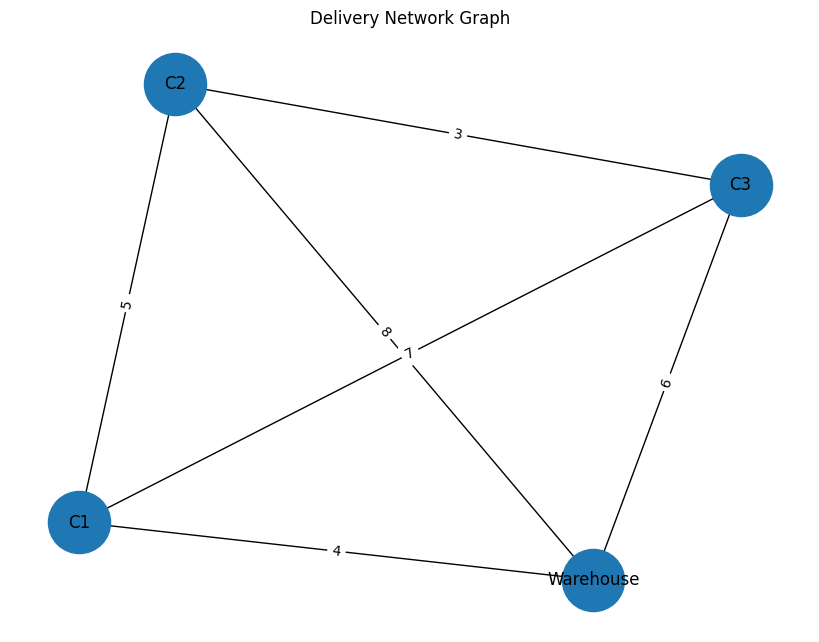

In [19]:
G = nx.Graph()

for i in range(len(locations)):
    for j in range(i+1, len(locations)):
        G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

pos = nx.spring_layout(G)

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=12)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Delivery Network Graph")
plt.show()


Visualization — Profit vs Weight

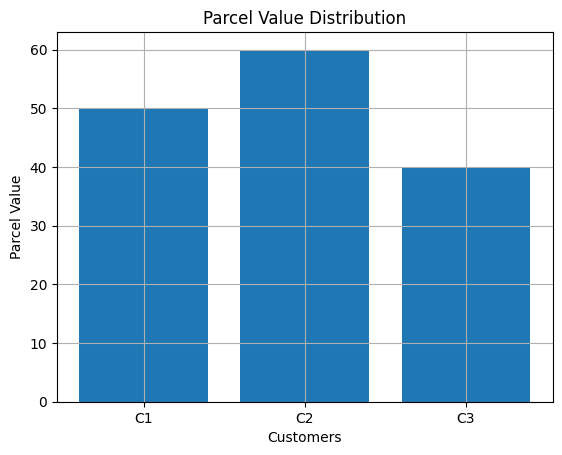

In [20]:
weights = [parcels[c]['weight'] for c in parcels]
values = [parcels[c]['value'] for c in parcels]

plt.bar(parcels.keys(), values)
plt.xlabel("Customers")
plt.ylabel("Parcel Value")
plt.title("Parcel Value Distribution")
plt.grid()
plt.show()


Profiling TSP Execution Time Growth

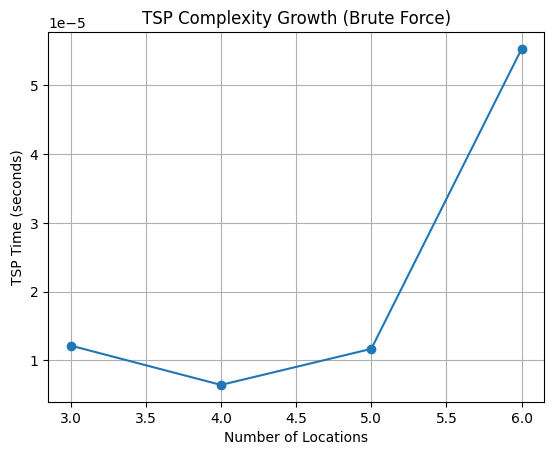

In [22]:
def tsp_simple(loc, dm):
    # Pure brute force TSP without time windows
    n = len(loc)
    idx = list(range(1, n))
    best = float('inf')

    for perm in itertools.permutations(idx):
        cost = dm[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dm[perm[i]][perm[i+1]]
        cost += dm[perm[-1]][0]

        if cost < best:
            best = cost

    return best


def profile_tsp(n):
    # Create synthetic locations
    loc = ['W'] + [f'C{i}' for i in range(1, n)]

    # Synthetic distance matrix
    dm = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            dm[i][j] = abs(i-j)+1 if i != j else 0

    # Time the simple TSP
    start = time.time()
    tsp_simple(loc, dm)
    end = time.time()

    return end - start


sizes = [3, 4, 5, 6]
times = [profile_tsp(s) for s in sizes]

plt.plot(sizes, times, marker='o')
plt.xlabel("Number of Locations")
plt.ylabel("TSP Time (seconds)")
plt.title("TSP Complexity Growth (Brute Force)")
plt.grid()
plt.show()
